In [2]:
#from coordinate_descent import SparseCoordinateDescentSVM
from CDSVM_Michal_archive import CoordinateDescentSVM
import data_loader
import time

In [2]:
X_tr,X_test, y_tr, y_test = data_loader.load_dataset('../data/paper_data/news20.binary')

In [3]:
print("Shape:", X_tr.shape)
print("Sparsity:", 100 * (1 - X_tr.nnz / (X_tr.shape[0] * X_tr.shape[1])), "%")


Shape: (15996, 1355192)
Sparsity: 99.96638617384322 %


In [37]:
from  sklearn.svm import LinearSVC
model = LinearSVC()
model.fit(X_tr,y_tr)

LinearSVC()

In [3]:
model = SparseCoordinateDescentSVM()

In [4]:
model.fit(X_tr,y_tr)

0
0
1
2
3
4
5
6
7
8


KeyboardInterrupt: 

In [3]:
model = CoordinateDescentSVM()
model.fit(X_tr,y_tr)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [10]:
print(X_tr.shape)
print(np.ones((X_tr.shape[0], 1)).shape)
X_ext = np.hstack([X_tr, np.ones((X_tr.shape[0], 1))])

(15996, 1355192)
(15996, 1)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [3]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

# Załaduj dane w formacie sparse

# Linear SVM (działa dobrze na sparse)
clf = LinearSVC(dual=False)  # dual=False działa lepiej, gdy n_samples > n_features
clf.fit(X_tr, y_tr)

#print("Test accuracy:", clf.score(X_test, y_test))


NameError: name 'X_tr' is not defined

In [6]:
X_tr.shape

(15996, 1355192)

# Tutaj są moje zmiany!

In [136]:
import numpy as np
import time
from scipy.sparse import issparse, csc_matrix


class SparseCoordinateDescentSVM_2:
    def __init__(self, C=1.0, max_iter=10000, tol=1e-8, sigma=0.01, beta=0.5, verbose=True):
        self.C = C
        self.max_iter = max_iter
        self.tol = tol
        self.sigma = sigma
        self.beta = beta
        self.verbose = verbose
        self.w = None
        self.z = None
        self.lambdas = {}
        self.times = []
        self.relative_diffs = []
        self.obj_values =[]
        self.time_start = time.time()
    def _d_prime_i_0(self, xji, y, i):
        margins = 1 - y * self.z
        active = margins > 0
        y_active = y[active]
        margins_active = margins[active]
    
        # Kolumna i w formacie CSC
        #xji = X[:, i]
    
        # Tylko niezerowe wartości
        start_ptr, end_ptr = xji.indptr[0], xji.indptr[1]
        row_indices = xji.indices[start_ptr:end_ptr]
        data = xji.data[start_ptr:end_ptr]
    
        # Filtrowanie tylko aktywnych przykładów
        mask = active[row_indices]
        if not np.any(mask):
            return self.w[i]  # brak aktywnych
    
        filtered_y = y[row_indices][mask]
        filtered_margins = margins[row_indices][mask]
        filtered_data = data[mask]
    
        gradient_sum = np.sum(filtered_data * filtered_y * filtered_margins)
        return self.w[i] - 2 * self.C * gradient_sum
#    def _d_prime_i_0(self, X, y, i):
#        margins = 1 - y * self.z

#        active = margins > 0

#        bj = margins[active]

#        y_active = y[active]
    
        # Pobierz kolumnę i
#        xji = X[:, i]
#        xji_data = xji.toarray().ravel()[active]  # tylko aktywne wartości

#        gradient_sum = np.sum(xji_data * y_active * bj)

    
        # Oblicz gradient sum w pełni w sparse
#        gradient_sum = xji.multiply(y_active * bj).sum()
#        return self.w[i] - 2 * self.C * gradient_sum

#    def _d_double_prime_i_0(self, X, y, i):
        
#        margins = 1 - y * self.z
#        active = margins > 0
#        xji = X[active, i]

#        if issparse(xji):
#            hessian_sum = xji.multiply(xji).sum()
#        else:
#            hessian_sum = np.sum(xji ** 2)

#        return 1 + 2 * self.C * hessian_sum

    def _d_double_prime_i_0(self, xji, y, i):
        margins = 1 - y * self.z
        active = margins > 0
    
        # Kolumna i z macierzy X (CSC format)
        #xji = X[:, i]
    
        # Niezerowe indeksy i wartości w kolumnie i
        start_ptr = xji.indptr[0]
        end_ptr = xji.indptr[1]
        row_indices = xji.indices[start_ptr:end_ptr]
        values = xji.data[start_ptr:end_ptr]
    
        # Filtrowanie aktywnych przykładów
        active_mask = active[row_indices]
        if not np.any(active_mask):
            return 1.0  # tylko regularizacja, brak strat
    
        filtered_values = values[active_mask]
    
        # Obliczenie sumy kwadratów tylko dla aktywnych niezerowych xji
        hessian_sum = np.sum(filtered_values ** 2)
        return 1.0 + 2 * self.C * hessian_sum

    def _newton_direction(self, X, y, i,  denominator = None):
        xji = X[:, i]
        numerator = self._d_prime_i_0(xji, y, i)

        if (denominator == None):
            denominator = self._d_double_prime_i_0(xji, y, i)
        return -numerator / denominator if denominator != 0 else 0.0

    #def _d_i_z(self, X, y, i, z):
        #ei = np.zeros(X.shape[1])
        #ei[i] = 1
        #w_new = self.w + z * ei
        #margins = 1 - y * (X @ w_new)
        #active = margins > 0
        #loss_term = np.sum(margins[active] ** 2)
        #return 0.5 * np.dot(w_new, w_new) + self.C * loss_term
    def _d_i_z(self, X, y, i, z):
        # Zmiana tylko w jednej współrzędnej — delta_z to sparse wektor
        x_col = X[:, i]  # to jest kolumna w CSC formacie (sparse column)
    
        delta_z = x_col.multiply(z)       # sparse * scalar
        z_new = self.z + delta_z.toarray().ravel()  # tylko teraz musimy do dense, bo self.z jest dense
    
        margins = 1 - y * z_new
        active = margins > 0
        loss_term = np.sum(margins[active] ** 2)
    
        # ||w_new||^2 = ||w||^2 + 2z * w_i + z^2
        w_norm_sq = np.dot(self.w, self.w) + 2 * z * self.w[i] + z**2
    
        return 0.5 * w_norm_sq + self.C * loss_term

    def _compute_constant_lambda(self, X, y, i):
        Xi_col = X[:, i]
        dii = self._d_double_prime_i_0(Xi_col, y, i)

        if issparse(Xi_col):
            Xi_squared_sum = Xi_col.multiply(Xi_col).sum()
        else:
            Xi_squared_sum = np.sum(Xi_col ** 2)

        Hi = 1 + 2 * self.C * Xi_squared_sum
        return dii / (0.5 * Hi + self.sigma), dii

    def _compute_lambda(self, X, y, i, d):
        lambda_bar = self.lambdas[i]
        if abs(d) < 1e-12:
            return 0.0
        if 1.0 <= lambda_bar:
            return 1.0

        # Otherwise, perform line search
        D0 = self._d_i_z(X, y, i, 0)
        k = 0
        while True:
            lam = self.beta ** k
            z = lam * d
            Dz = self._d_i_z(X, y, i, z)
            if Dz - D0 <= -self.sigma * (z ** 2):
                return lam
            k += 1
            if k > 20:  # Prevent infinite loop
                return lam

    def _coordinate_update(self, X, y, i, z,dii = None):
        d = self._newton_direction(X, y, i, dii)
        if abs(d) < 1e-12:
            return
        lam = 1.0
        if i in self.lambdas:
            if 1.0 > self.lambdas[i]:  # Only check line search if needed
                lam = self._compute_lambda(X, y, i, d)
        else:
            self.lambdas[i] = self._compute_constant_lambda(X, y, i)
            if 1.0 > self.lambdas[i]:
                lam = self._compute_lambda(X, y, i, d)
                
        delta = lam * d
        self.w[i] += delta
        x_col = X[:, i]
        self.z[x_col.indices] += delta * x_col.data



    def fit(self, X, y):
        if not issparse(X) or not isinstance(X, csc_matrix):
            raise ValueError("X must be a CSC (Compressed Sparse Column) matrix")
        #start with initial w0
        best_obj = float('inf')

        self.w = np.zeros(X.shape[1],dtype=np.float64)
        self.z = X.dot(self.w)
        for iteration in range(self.max_iter):
            w_old = self.w.copy()
            i = np.random.randint(0, X.shape[1])
            if i not in self.lambdas:
                self.lambdas[i], dii = self._compute_constant_lambda(X, y, i)
            else:
                dii = None
            self._coordinate_update(X, y, i, dii)
            if iteration % 100 == 0 or iteration == self.max_iter - 1:
                delta = np.linalg.norm(self.w - w_old)
                print(f"Iter {iteration}, Δw = {delta:.2e},error = {1-self.score(X,y):.3e}")

                elapsed_time = time.time() - self.time_start
                self.times.append(elapsed_time)
    

    
            if delta < self.tol:
                if self.verbose:
                    print(f"Converged at iteration {iteration}")
                break
        return self


    def predict(self, X):
        return np.sign(X @ self.w)

    def score(self, X, y):
        return np.mean(self.predict(X) == y)
        
    def _objective(self, X, y):
        margins = 1 - y * self.z
        loss = np.sum((margins[margins > 0]) ** 2)
        return 0.5 * np.dot(self.w, self.w) + self.C * loss




In [137]:
model = SparseCoordinateDescentSVM_2(C = 1, tol = 0, verbose = True )


Iter 0, Δw = 4.64e-02,error = 9.999e-01
Iter 100, Δw = 4.75e-03,error = 9.826e-01
Iter 200, Δw = 1.44e-01,error = 9.645e-01
Iter 300, Δw = 4.64e-01,error = 9.508e-01
Iter 400, Δw = 6.87e-02,error = 9.339e-01
Iter 500, Δw = 3.06e-02,error = 9.228e-01
Iter 600, Δw = 9.01e-02,error = 9.027e-01
Iter 700, Δw = 3.37e-02,error = 8.872e-01
Iter 800, Δw = 3.87e-01,error = 8.635e-01
Iter 900, Δw = 1.45e-01,error = 8.479e-01
Iter 1000, Δw = 3.82e-01,error = 8.118e-01
Iter 1100, Δw = 2.11e-02,error = 7.955e-01
Iter 1200, Δw = 4.98e-01,error = 7.764e-01
Iter 1300, Δw = 9.29e-02,error = 7.681e-01
Iter 1400, Δw = 8.09e-02,error = 7.592e-01
Iter 1500, Δw = 3.27e-02,error = 7.507e-01
Iter 1600, Δw = 2.54e-01,error = 7.115e-01
Iter 1700, Δw = 1.07e-01,error = 7.041e-01
Iter 1800, Δw = 2.10e-01,error = 6.966e-01
Iter 1900, Δw = 5.02e-01,error = 6.735e-01
Iter 2000, Δw = 3.46e-01,error = 6.679e-01
Iter 2100, Δw = 3.34e-01,error = 6.587e-01
Iter 2200, Δw = 1.91e-01,error = 6.492e-01
Iter 2300, Δw = 9.20e-0

ValueError: x and y must have same first dimension, but have shapes (101,) and (0,)

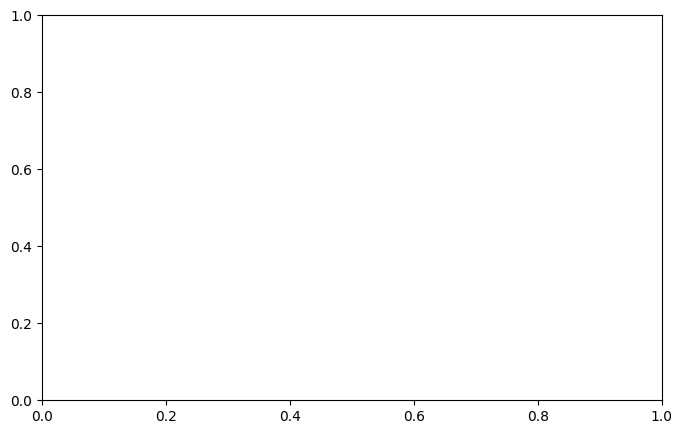

In [138]:
model.fit(X,y)

In [6]:
def load_svm_file(file_path, zero_based=True):
    labels = []
    rows = []
    cols = []
    data = []

    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            parts = line.strip().split()
            labels.append(float(parts[0]))

            for feat in parts[1:]:
                idx, val = feat.split(':')
                idx = int(idx) - (0 if zero_based else 1)
                rows.append(i)
                cols.append(idx)
                data.append(float(val))

    # Jawna konwersja do CSC
    from scipy.sparse import coo_matrix
    X = coo_matrix((data, (rows, cols))).tocsc()
    y = np.array(labels)

    return X, y
X,y =load_svm_file('../data/paper_data/news20.binary')

In [39]:
X[:,2]

<19996x1 sparse matrix of type '<class 'numpy.float64'>'
	with 76 stored elements in Compressed Sparse Column format>